# Lab 3 Vision par ordinateur : Apprentissage profond

Author: Mohsen Benlazreg M.ing en GPA

Mise à jour: Étienne Pepin

REF : https://keras.io/examples/
#### requirements :
numpy  
sklearn  
tensorflow

## Séance 2 : Utilisation des architectures pré-entraînées

Une approche courante et très efficace de l'apprentissage profond consiste à conserver une partie d'un réseau de neurones pré-entrainé. Un réseau pré-entrainé est simplement un réseau entrainé sur une grande base données, généralement sur une tâche de classification d'images à grande échelle.

Si cette base de données utilisée est assez grande et assez générale, alors la hiérarchie des caractéristiques spatiales apprise par le réseau pré-entrainé peut effectivement agir comme un modèle générique de notre monde visuel, et donc ses caractéristiques peuvent s'avérer utiles pour de nombreux problèmes de vision par ordinateur différents, même si ces nouveaux problèmes puissent impliquer des classes complètement différentes.

Dans notre cas, nous considérerons un grand convnet entrainé sur la base de données ImageNet (1,4 million d'images étiquetées et 1000 classes différentes).

Nous utiliserons l'architecture VGG16, développée par Karen Simonyan et Andrew Zisserman en 2014, une architecture convnet simple et largement utilisée.

C'est un modèle un peu plus ancien, loin de l'état de l'art actuel mais nous l'avons choisi car son architecture est facile à comprendre sans introduire de nouveaux concepts.

Le modèle VGG16 est donné dans le framework Keras. Vous pouvez l'importer depuis le module `keras.applications`. Voici la liste quelques modèles pré-entrainé sur ImageNet fournit par Keras:
* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Il existe deux façons d'exploiter un réseau pré-entrainé :
- Utiliser ce réseau comme un extracteur de caractéristiques.
- Adapter une partie de ce réseau par un petit entrainement. 

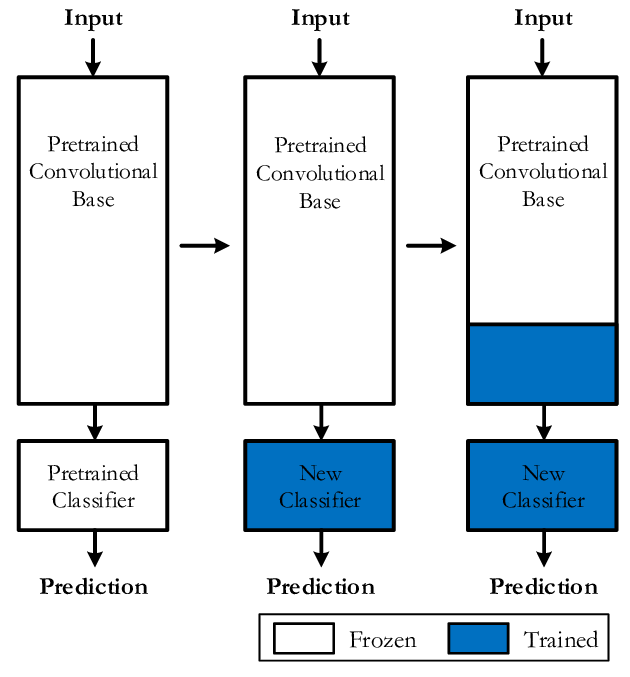
![source] https://www.researchgate.net/figure/TOP-LEVEL-DIAGRAM-OF-TRANSFER-LEARNING-FROM-A-PRE-TRAINED-CNN-MODEL_fig4_333882146

## Partie 1 : Extraction de caractéristiques 

Cette technique consiste à utiliser la partie d'extraction de caractéristiques " `conv_base` " du CNN. 


In [51]:
import tensorflow as tf
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.8.0'

In [52]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6388535957999186090
xla_global_id: -1
]


In [53]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [54]:
conv_base.trainable = False # l'entrainement va pas affecter cette partie
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

La dernière couche est une couche de pooling de forme (4,4,512), c'est à partir de cette couche qu'on va coller un un perceptron multicouche pour la classification.

### Exercice 1 :

1- Ajouter une couche de flatten et un perceptron multicouche (à vous de choisir les hyper-paramétres : nombre de couches, nombre de neurones dans chaque couche, fonction d'activation).

(indice: 
model = models.Sequential()

model.add(conv_base)

model.add(layers.Flatten())
)

2 - Faire le preprocessing des données mini-caltech101 pour que vos images soient preprocess de la même façon qu'elles l'étaient lors de l'entraînement de VGG16

voir https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input, prêter attention à l'input range des images de cette fonction.
   
3- Faire l'entrainement sur  avec un lr=1e-5 pendant 20 époques.
    
4- Tracer les courbes de précision et d'erreur et comparer les résultats obtenus avec les résultats du lab
précedent. 



In [55]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))
model.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))
model.add(layers.Dense(10, activation='softmax'))

In [56]:
import os
import cv2
import numpy as np

def load_data (data_path,img_shape):
    data_dir_list = os.listdir(data_path)
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    num_channel=img_shape[2]


    labels=[]
    data=[]
    len_list_img=0
    num_class=0
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)    
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.resize(input_img,(img_rows,img_cols))
            data.append(input_img)
            labels.append(num_class)
        num_class+=1

    data = np.array(data)
    data = data.astype('float32')
    data /= 255
    labels=np.array(labels)
    print('data shape',data.shape)
    print('labels shape',labels.shape)
    return data, labels

In [57]:
data_path='/Users/claramacabiau/Documents/Canada/Cours_ETS/SYS809/lab3_1/mini_Caltech101'
img_shape=[224,224,3]
data, labels=load_data (data_path,img_shape)

data shape (500, 224, 224, 3)
labels shape (500,)


In [58]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
num_classes=10
Y = to_categorical(labels, num_classes)
X_train,y_train = shuffle(data,Y, random_state=2)
X_train, X_test, y_train , y_test = train_test_split(X_train,y_train, test_size=0.3, random_state=2)

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras import layers


sgd = SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               12845568  
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 10)                5130      
                                                                 
Total params: 27,828,042
Trainable params: 13,113,354
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
n_epoch=20
hist = model.fit(X_train, y_train, batch_size=15, epochs=n_epoch, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
24/24 [==============================] - 125s 5s/step - loss: 2.3866 - accuracy: 0.0914 - val_loss: 2.3363 - val_accuracy: 0.1000
Epoch 2/20
24/24 [==============================] - 106s 4s/step - loss: 2.2677 - accuracy: 0.1200 - val_loss: 2.2393 - val_accuracy: 0.1733
Epoch 3/20
24/24 [==============================] - 108s 5s/step - loss: 2.1658 - accuracy: 0.2600 - val_loss: 2.1587 - val_accuracy: 0.3067
Epoch 4/20
24/24 [==============================] - 109s 5s/step - loss: 2.0784 - accuracy: 0.3829 - val_loss: 2.0872 - val_accuracy: 0.4067
Epoch 5/20
24/24 [==============================] - 112s 5s/step - loss: 2.0015 - accuracy: 0.5086 - val_loss: 2.0233 - val_accuracy: 0.4867
Epoch 6/20
24/24 [==============================] - 135s 6s/step - loss: 1.9304 - accuracy: 0.6200 - val_loss: 1.9628 - val_accuracy: 0.5200
Epoch 7/20
24/24 [==============================] - 135s 6s/step - loss: 1.8647 - accuracy: 0.6857 - val_loss: 1.9047 - val_accuracy: 0.6067
Epoch 8/20
24

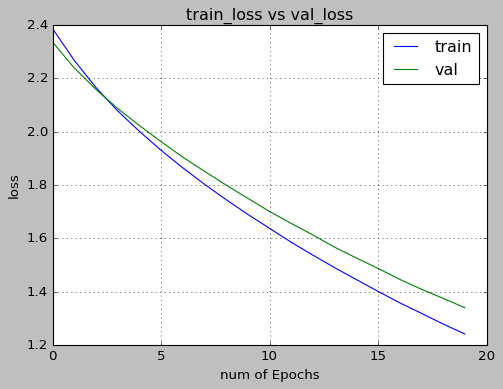

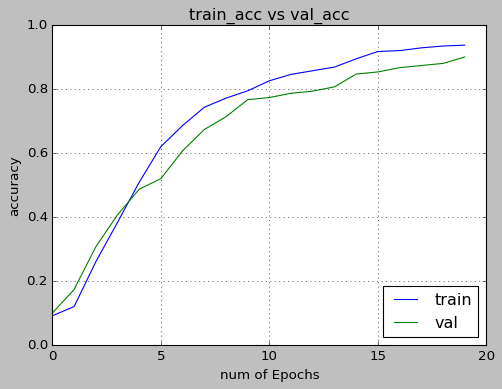

In [60]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(n_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

## Partie 2 : Adaptation d'un CNN pré-entraîné   

Dans cette partie, on va faire un petit réglage pour quelques couches de convolution de notre modèle. Cette méthode ajuste légèrement les représentations les plus abstraites du modèle réutilisé, afin de les rendre plus pertinentes pour le problème en question.


In [61]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     


Les étapes suivantes résument cet algorithme :

1- Ajouter un perceptron multicouche.

2- Débloquer quelques couches de la base de convolution. 

3- Faire l'entrainement. 

Par exemple, on va débloquer les couches qui suivent `block4_pool` et laisser les autres bloquées. C'est à dire, les couches `block5_conv1`, `block5_conv2` et `block5_conv3` vont être modifiées lors de l'entrainement.

In [62]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### Exercice 2:

1- Réaliser l'entrainement du CNN pré-entrainé adapté sur mini-caltech101 (lr=1e-5, 20 époques). 

2- Comparer les résultats obtenus avec les résultats de l'exercice 1. 

3- Expliquer pourquoi on utilise un lr (learning rate) faible.
    

In [63]:
model2 = models.Sequential()

model2.add(conv_base)

model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))
model.add(layers.Dense(512, activation='relu', input_shape=(7* 7,)))
model2.add(layers.Dense(10, activation='softmax'))

In [66]:
sgd = SGD(learning_rate=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])

In [67]:
n_epoch=20
hist = model2.fit(X_train, y_train, batch_size=15, epochs=n_epoch, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
24/24 [==============================] - 147s 6s/step - loss: 2.4338 - accuracy: 0.1343 - val_loss: 2.2274 - val_accuracy: 0.2333
Epoch 2/20
24/24 [==============================] - 133s 6s/step - loss: 2.1286 - accuracy: 0.3514 - val_loss: 2.0362 - val_accuracy: 0.4600
Epoch 3/20
24/24 [==============================] - 123s 5s/step - loss: 1.9446 - accuracy: 0.5114 - val_loss: 1.8810 - val_accuracy: 0.5667
Epoch 4/20
24/24 [==============================] - 124s 5s/step - loss: 1.7864 - accuracy: 0.6171 - val_loss: 1.7500 - val_accuracy: 0.6667
Epoch 5/20
24/24 [==============================] - 123s 5s/step - loss: 1.6455 - accuracy: 0.6914 - val_loss: 1.6199 - val_accuracy: 0.7533
Epoch 6/20
24/24 [==============================] - 123s 5s/step - loss: 1.5100 - accuracy: 0.7657 - val_loss: 1.5064 - val_accuracy: 0.7867
Epoch 7/20
24/24 [==============================] - 127s 5s/step - loss: 1.3882 - accuracy: 0.8343 - val_loss: 1.3977 - val_accuracy: 0.8400
Epoch 8/20
24

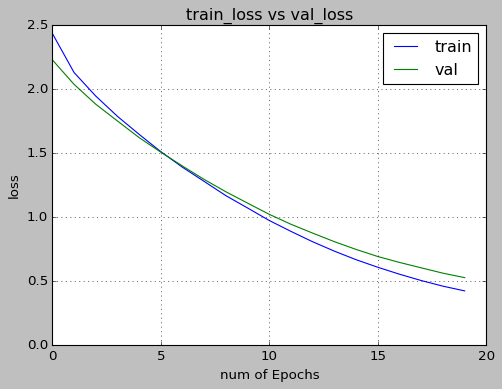

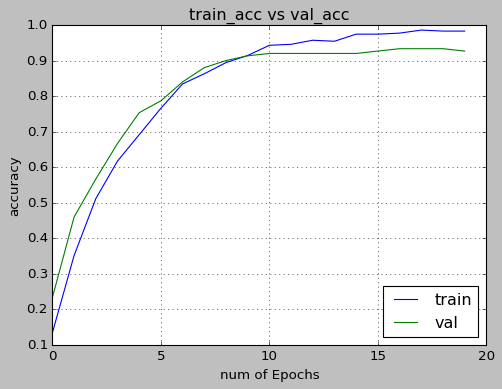

In [68]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(n_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])

2- Les pertes sont plus faible et la précision est meilleure. C'est parce que le réseau est déjà pré-entraîné.

3- Un learning rate faible permet de réduire les pertes. En effet, le learning rate est utilisé dans l'algorithme de descente de gradient pour déterminer le prochain point à utiliser dans l'algorithme. Plus le learning rate est faible, plus les points sont proches. 

## Partie 3 : KNN + CNN pré-entrainé

### Exercice 3 : 
1- Ajouter le VGG entrainé sur ImageNet. (indice : include_top = True)

- Pour la bases de données mini-caltech101 :

2- Extraire le vecteur de caractéristique de l'avant dernière couche. (vecteur de 4096 valeurs)

(indice : 
get_layer_output= K.function([model.input], [model.layers[layer_idx].output])

avec le `num_layer` et le numéro de la couche en considération)


3- Utiliser KNN pour classifier les images (K=1). 

(indice : from sklearn.neighbors import KNeighborsClassifier)

4- Comparer les résultats obtenues avec les résultats de l'exercice 1 et 2. 

In [17]:
from tensorflow.keras.applications import VGG16

vgg_2 = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))
vgg_2.summary()                 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
import tensorflow.keras.backend as K

get_layer_output= K.function([vgg_2.input], [vgg_2.layers[-2].output])
vgg_2.layers[-2].output

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

data2 = data.reshape((data.shape[0], 224*224*3))
num_classes=10
Y = to_categorical(labels, num_classes)
X_train,y_train = shuffle(data2,Y, random_state=2)
X_train, X_test, y_train , y_test = train_test_split(X_train,y_train, test_size=0.3, random_state=2)

le = LabelEncoder()
labels = le.fit_transform(labels)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.40      0.80      0.53        15
           1       0.40      0.13      0.20        15
           2       1.00      1.00      1.00        17
           3       0.27      0.27      0.27        15
           4       0.32      0.43      0.36        14
           5       0.86      0.86      0.86        14
           6       0.52      0.68      0.59        19
           7       1.00      0.31      0.47        13
           8       0.75      0.43      0.55        14
           9       0.69      0.64      0.67        14

   micro avg       0.57      0.57      0.57       150
   macro avg       0.62      0.55      0.55       150
weighted avg       0.62      0.57      0.56       150
 samples avg       0.57      0.57      0.57       150



## Évaluation : 

Exercice 1 : 30%
    
Exercice 2 : 30%
    
Exercice 3 : 40%